In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tqdm

In [3]:
torch.__version__

'1.5.0'

In [4]:
# # Create a simple LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(out[:, -1, :])  # Take only the output of the last time step
#         out = self.fc(out)
#         return out


In [5]:

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [6]:
# Prepare data for training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [7]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.txt')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


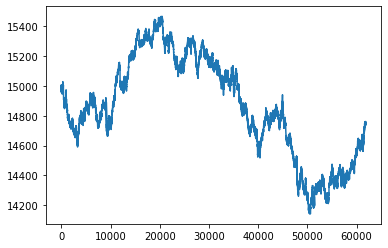

In [8]:
plt.plot(df['close'])
plt.show()

In [9]:
# Preprocess the data
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_scaled = scaler.fit_transform(df[['close']].values)

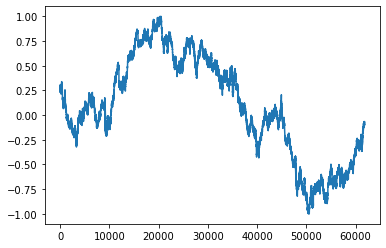

In [10]:
plt.plot(prices_scaled)

In [11]:
seq_length = 59
X, y = create_sequences(prices_scaled, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

# AAAAAAAAAAAAAAAAAAAA fcking shape!
y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))


test_set_size = int(np.round(0.2*X.shape[0]));
train_set_size = X.shape[0] - (test_set_size);


X_train = X[:train_set_size]
y_train = y[:train_set_size]
X_test = X[train_set_size:]
y_test = y[train_set_size:]


print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)



X_train.shape =  torch.Size([49419, 59, 1])
y_train.shape =  torch.Size([49419, 1])
X_test.shape =  torch.Size([12355, 59, 1])
y_test.shape =  torch.Size([12355, 1])


In [12]:
torch.min(X), torch.max(X)

(tensor(-1.), tensor(1.))

In [13]:
# validation
print(X.shape, y.shape)

for u in range(1000):
    assert y[u] == X[u+1][-1][0]
print('All good')

torch.Size([61774, 59, 1]) torch.Size([61774, 1])
All good


In [14]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

weight = np.ones(seq_length)/np.array(range(1,seq_length+1))
weight = torch.FloatTensor(weight).to(device)
weight

plt.plot(weight.to('cpu'))


class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return ((input - target)**2 ) * weight


weight=torch.FloatTensor([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

mse_criterion = weighted_MSELoss()
loss_mot_rec = mse_criterion(self.fake_noise,self.real_noise,weights).mean(dim = -1)

def weighted_mse_loss(input, target):
    
    return (weight * (input - target) ** 2)


?LSTM

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for idx, (batch_X, batch_y) in enumerate(train_loader):
    print(idx)
    print(batch_X.shape)
    break

batch_X[0].reshape(-1),batch_X[1].reshape(-1)

In [15]:
# Hyperparameters
input_size = 1 # number of features
hidden_size = 40 #
num_layers = 3
output_size = 1
num_epochs = 10
learning_rate = 0.01
batch_size = 128

In [16]:
# Initialize model, loss function, and optimizer
model = LSTM(input_dim=input_size, 
             hidden_dim=hidden_size,
             output_dim=output_size,
             num_layers=num_layers).to(device)
# https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
criterion = nn.MSELoss() # <<<
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

u_out = model.fc1(batch_X)

batch_X.shape

u_out.shape

u_out.shape

u_out[0]

u_out[:,-1,:]

model.fc2(u_out)

In [17]:
# train_data   = torch.utils.data.TensorDataset(X, y)
# train_loader = torch.utils.data.DataLoader(dataset=train_data,
#                                                batch_size=batch_size,
#                                                shuffle=True)
# Train model
#####################
num_epochs = 100
hist = []
# hist = np.zeros((int(len(train_data)/128)+1)*num_epochs)

# Number of steps to unroll
seq_dim =60
batch_size=512
t = 0
# model.train()
for t in tqdm.tqdm_notebook(range(num_epochs)):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    for batch_X, batch_y in train_loader:
        t+=1
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # Forward pass
        y_train_pred = model(batch_X)

        loss = criterion(y_train_pred, batch_y)
        if t % 100 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist.append(loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

Epoch  100 MSE:  0.00013846837100572884
Epoch  100 MSE:  0.00012658402556553483
Epoch  100 MSE:  8.772501314524561e-05
Epoch  100 MSE:  8.969382906798273e-05
Epoch  100 MSE:  0.00010988979192916304
Epoch  100 MSE:  0.00010305421892553568
Epoch  100 MSE:  7.720571738900617e-05
Epoch  100 MSE:  7.497634214814752e-05



KeyboardInterrupt: 

Train Idx [0:8238] 
Test  Idx [8239:16474]


[0.01487842 0.01428463 0.01473755 0.01471683 0.01463315 0.01514362
 0.01450782 0.01493169 0.01409493 0.01446904]
[-0.01970773 -0.04027493 -0.03714366  0.00133976 -0.03244928 -0.02617425
 -0.03324969 -0.02209421 -0.021037   -0.04880437]
[ 0.00200953 -0.10856822 -0.06210891  0.06505653  0.13414979  0.0549677
 -0.02980457  0.00313979  0.15436137 -0.14774895]
[ 0.13137227 -0.07459246  0.11773631 -0.0290678  -0.02426826 -0.16544561
  0.11108506  0.11084121 -0.04007209 -0.17636997]
[ 0.04013526  0.19031519  0.0687526  -0.02045369 -0.0591782   0.01711227
 -0.11720453 -0.08784895  0.12473746 -0.02830482]
[ 0.15821591  0.1606864  -0.1784612   0.05667567  0.23139274  0.04436435
 -0.0824784   0.17833173  0.02682564 -0.05342656]
[-0.19813967  0.03184914 -0.05947295 -0.11549528  0.16109727 -0.02425694
  0.16346218 -0.06535235  0.18809114  0.04865942]
[ 0.10335964  0.18073764  0.16756019 -0.0618187  -0.11116104  0.05843662
  0.10609919 -0.05759142  0.11056218  0.05941145]
[-0.01572387 -0.14537835  0

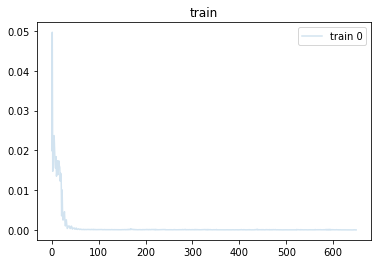

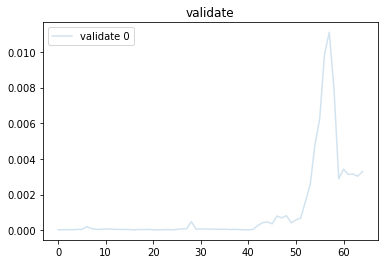

Train Idx [0:16474] 
Test  Idx [16475:24710]


[0.26592684 0.06906898 0.39854467 0.12347644 0.1216291  0.5985477
 0.65356714 0.6722742  0.19896099 0.11127502]
[ 0.10459873  0.07621342  0.60392916 -0.02366148  0.5856762   0.02939617
  0.63709044  0.14635132 -0.00072176  0.58546567]
[ 0.67941296  0.37370878 -0.00898059 -0.05642585  0.6905603   0.41539297
 -0.14235906  0.5878972  -0.0311503  -0.14012991]
[ 0.5211723  -0.063232    0.08878419  0.72713363 -0.02711498 -0.10946219
 -0.07680303  0.74599427 -0.08022442  0.6265648 ]
[-0.03101647  0.42224163 -0.11769405  0.08857737  0.15763752  0.2583809
 -0.03500611  0.10903245  0.04562195  0.630749  ]
[0.09826794 0.12669507 0.38391787 0.6293676  0.08343241 0.6291349
 0.26054224 0.16249436 0.1794317  0.08825359]
[-0.12019622  0.36668712  0.06961508  0.60044277  0.5931398   0.29537365
 -0.04715626 -0.20433527  0.13543913  0.28167593]
[ 0.82788527  0.6029725   0.1876315   0.57063425  0.16573295  0.45813054
  0.09289202  0.0916255  -0.12217823  0.14344543]
[-0.05075904 -0.04761146 -0.03256454  0

[-0.13363406 -0.14389464  0.20555802  0.30174768  0.15285197 -0.04246327
  0.6009851   0.7361426   0.09053208  0.0546863 ]
[-0.04556407  0.17288621  0.6232785  -0.15067904  0.08183983  0.10559864
  0.01932911  0.8344624   0.72504854  0.55100155]
[ 0.70462286  0.77751666  0.72555786  0.6991139   0.15291367  0.31275645
 -0.08958951  0.1842226  -0.01323777 -0.01493314]
[-0.19877216 -0.05057537  0.5766121   0.06682788  0.15445216  0.03183708
 -0.06285532  0.09316568  0.16981296  0.27230406]
[ 0.09342086 -0.12255487 -0.13270032  0.2593605   0.42591488 -0.02690312
 -0.05474658  0.3082105   0.50093025 -0.01119165]
[ 0.5764211   0.30141485  0.17458448 -0.20906903  0.05742523  0.1913668
  0.15567513 -0.19690314 -0.11069508  0.16750416]
[-0.08096951  0.13199595  0.7001238  -0.09950496 -0.17302468  0.18306477
  0.21982023 -0.0597164   0.699276    0.15851688]
[ 0.2688047  -0.03717354 -0.11055572  0.09756403 -0.04376877  0.199521
  0.12125463  0.32556763  0.33963856 -0.1422245 ]
[-0.04402921 -0.059

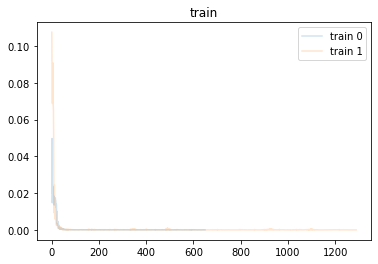

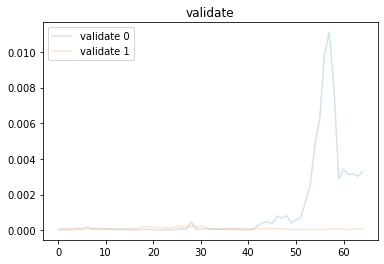

Train Idx [0:24710] 
Test  Idx [24711:32946]


[0.22382297 0.3892663  0.18552244 0.1854218  0.21921115 0.2206426
 0.36937046 0.39156002 0.19692104 0.24098   ]
[0.0548144  0.05634631 0.05492149 0.05489464 0.05487463 0.06617858
 0.4910531  0.0550383  0.05485597 0.4905256 ]
[0.78156036 0.03048162 0.0351985  0.03071295 0.03729747 0.03377022
 0.04371772 0.7622744  0.78112555 0.7736419 ]
[ 0.6361416   0.64342177  0.5438134  -0.01217508 -0.09602825  0.56600314
  0.64733094  0.18038617  0.57596976  0.34375003]
[-0.08907774  0.43491784  0.77933437 -0.03843404  0.45065153  0.7954926
  0.85696715  0.9673656   0.00854836 -0.08035085]
[ 0.05833438  0.26414305  0.8253272   0.03648137  0.49837863  0.8048261
 -0.15311958  0.08075953 -0.18497224  0.3445452 ]
[ 0.8913584   0.5284276  -0.07637943 -0.05240917  0.77522635  0.5927021
 -0.0261094   0.5499578   0.7815963   0.71374106]
[ 0.43004918 -0.02764791 -0.01950589 -0.12452088 -0.00879265  0.03906815
 -0.09445794  0.2377077   0.76624113 -0.1092758 ]
[ 0.00684862  0.83571434  0.88026476  0.79083246 -

[ 0.47145283 -0.04447059  0.43767244  0.7887913   0.4620992   0.22015336
  0.31266975  0.46101403  0.7742667   0.78023916]
[ 0.04655634  0.9394152  -0.04638654  0.61820865  0.5431559   0.14925845
  0.55914414  0.10800877  0.26457417 -0.12748048]
[ 0.15905562  0.94901395  0.7156317  -0.10198644  0.252062    0.06763326
  0.07122041  0.0787844   0.78648233  0.73626953]
[ 0.01980542  0.8012087   0.09547715  0.7506322   0.20821188 -0.00182116
 -0.06789014  0.11043208  0.09188935  0.78312784]
[ 0.35256416  0.89231926  0.11280686  0.15804943 -0.03464167 -0.09918936
  0.7228187   0.16655764  0.6715242   0.31778002]
[0.46535847 0.9573731  0.8454149  0.04089756 0.80965704 0.20939316
 0.72903645 0.68027174 0.75275403 0.75472814]
[0.7291525  0.7062806  0.6933036  0.78128296 0.95966685 0.84951013
 0.6473497  0.6452788  0.39853433 0.0520992 ]
[-0.19246396 -0.13836989 -0.03384373  0.26090696  0.15045063  0.20492503
 -0.10948548  0.04886488  0.36858878  0.17572828]
[ 0.8023368   0.21166041  0.07412691

[ 0.5466116   0.5255335   0.6491012   0.57877016 -0.17482293  0.10413648
 -0.16700944  0.13512133 -0.01010074  0.11903535]
[ 0.76333493  0.30358794  0.5600882  -0.03082883 -0.21911663  0.7440784
  0.9429624  -0.09438667  0.52640486  0.16542453]
[ 0.30641028 -0.02458879  0.787626    0.9262148  -0.01144776  0.13020599
  0.12769851  0.14606306  0.43643928  0.45122096]
[ 0.7792153   0.0851894   0.2318858   0.17846417 -0.08800735 -0.06631263
 -0.159488    0.06404915  0.7335798  -0.03782268]
[-0.10208623  0.37731272  0.43238872  0.01370543  0.3109648   0.7620311
  0.92291695  0.8985349   0.59318566  0.69313383]
[ 0.7171327   0.77419037  0.16362534  0.2263147  -0.00434394  0.16632947
 -0.08950871 -0.0630312  -0.06216    -0.17987725]
[-0.11894323 -0.13676764  0.46429938 -0.09507437  0.5084521   0.71081626
  0.44572765  0.73243266  0.613913    0.51953954]
[-0.03417112  0.2939601  -0.03614469 -0.1027438  -0.04457596  0.38301027
  0.15624022  0.15151235  0.85641277  0.29501027]
[ 0.97074455  0.77

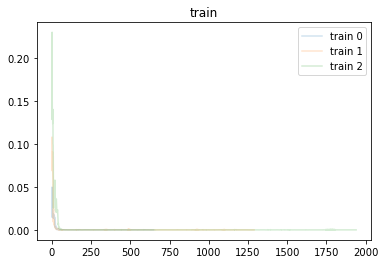

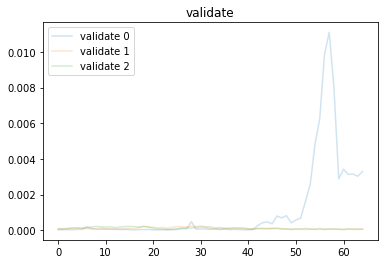

Train Idx [0:32946] 
Test  Idx [32947:41182]


[0.30711743 0.3118535  0.2877245  0.47448832 0.59714884 0.313214
 0.4350362  0.63054204 0.3082475  0.5043298 ]
[ 0.64284563  0.6436223   0.6509873   0.64389193  0.63394535  0.6488808
  0.62703973 -0.06315391  0.63364476  0.05846213]
[0.58873594 0.75679165 0.7681273  0.6358062  0.5717836  0.7521188
 0.7373267  0.8175051  0.05906828 0.0699302 ]
[ 0.48506907  0.46238938 -0.23661269  0.02979782  0.8451117   0.550291
  0.80264264  0.39563474  0.75869894  0.7405363 ]
[ 0.71300435  0.5041445   0.45912144  0.5458188   0.7396325   0.33561748
  0.27156892  0.48553053  0.7525846  -0.09362049]
[ 0.7292295   0.7699598   0.49465185  0.76742125  0.8533552   0.7859424
 -0.17594579  0.50815123  0.34116766  0.09339816]
[ 0.78647494  0.5464961   0.7483605   0.0802559   0.8590579   0.10711069
 -0.23811388  0.85824287  0.08136727  0.04997963]
[0.13689671 0.30943504 0.7802448  0.04211785 0.76277596 0.74317306
 0.6904518  0.7758638  0.10761003 0.48275906]
[ 0.0931339   0.17437112  0.743173    0.12221764 -0.1

[ 0.12136609 -0.00389378  0.4791132   0.5500239   0.6978348  -0.02330397
 -0.03841134  0.7129274  -0.04892112  0.28664705]
[ 0.6978997   0.5373823   0.7334898   0.3382893  -0.0933608   0.41669074
  0.8551404   0.1676955   0.87813646  0.7353239 ]
[ 0.767913    0.54634124 -0.20044407 -0.20516399  0.59133744 -0.08269753
  0.17338686 -0.04775272  0.75816745  0.88033164]
[-0.0664672   0.32011586  0.2709884   0.8112881   0.75655     0.79018646
 -0.05328521  0.732468    0.2577058   0.9250788 ]
[0.77349585 0.05465867 0.5437709  0.8660849  0.77957076 0.6212963
 0.47180697 0.6335955  0.5934293  0.16769387]
[ 0.18899526  0.2916269   0.79128724  0.9268953   0.72272855 -0.18409501
  0.71055084  0.7778494   0.87164444  0.57139385]
[ 0.33609137  0.50332     0.53691477  0.62689435 -0.16773911  0.120902
  0.20550533  0.08146721  0.5208365   0.6838103 ]
[ 0.5537289   0.5672375   0.53243566  0.571477    0.90495366  0.82430005
  0.78814036  0.6997247   0.4945538  -0.26114303]
[ 0.40758878  0.47894576  0.4

[0.09541211 0.8030541  0.7497151  0.6256463  0.57095814 0.34021047
 0.6224889  0.70824325 0.60412836 0.87073666]
[0.295832   0.49335918 0.151388   0.34100336 0.48678225 0.57267636
 0.51936346 0.55985796 0.16711332 0.282898  ]
[ 0.18797907 -0.15091477  0.8441747   0.75249445  0.48608857  0.164847
  0.540942   -0.16852395  0.5019794  -0.04166876]
[ 0.5163917   0.78778505 -0.0620864   0.8623305   0.8138513   0.7377265
  0.58865625  0.767804    0.49742436  0.0077845 ]
[ 0.27761158  0.3887832   0.19130053  0.09301993  0.30797467  0.6764715
  0.3675081   0.65353703  0.2237136  -0.1155249 ]
[ 0.4559617  -0.14995985  0.38568074 -0.03955287  0.6027952   0.48702127
  0.30111963  0.05405348  0.76008904  0.34316278]
[ 0.4768957   0.7188597   0.75543284  0.77581     0.5348128   0.5944674
  0.18021138 -0.09883537  0.91372544 -0.20251748]
[-0.07005176 -0.19623926  0.25419682  0.41776124 -0.08791742  0.9409377
  0.80328774 -0.08108689  0.09685044  0.60973024]
[-0.04887772  0.13560739  0.7685812   0.59

[0.76525134 0.10113102 0.09304421 0.9265504  0.78778386 0.05350044
 0.29830027 0.72157663 0.69254255 0.74627763]
[-0.20387387  0.10725643 -0.00887255  0.5965616   0.7553464   0.44263327
  0.7238821   0.5352974   0.46748942  0.01467394]
[-0.09266695  0.71182007  0.75891995  0.76642865  0.481187    0.33873427
  0.60570437  0.11525931  0.22523996  0.09740587]
[ 0.45608523  0.6139671  -0.0043582   0.13745669  0.35136348 -0.13401532
  0.15767434  0.53093773  0.60951346  0.3839135 ]
[-0.27158052  0.5857802  -0.03039538  0.5780222   0.79926085 -0.02340836
  0.5747134   0.09844859  0.31691095  0.5006823 ]
[-0.1590648   0.46148694 -0.08928047  0.05445704  0.14891039  0.8668934
  0.91381997  0.7727924   0.57412285  0.7431252 ]
[ 0.67512256  0.776282   -0.06004231  0.18074568  0.29077557 -0.02759085
  0.19706467  0.15215036  0.7742537   0.7722749 ]
[ 0.14444022  0.13042216 -0.03934218  0.1967602   0.46016774  0.38776684
  0.08427936  0.7345321  -0.12011184 -0.05291136]
[ 0.20287342  0.63238233  0

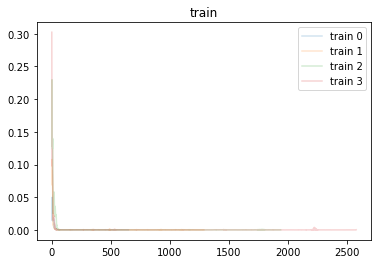

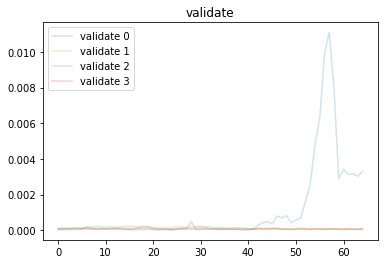

Train Idx [0:41182] 
Test  Idx [41183:49418]


[ 0.11686363  0.49113697  0.49850988 -0.04667233  0.30451912  0.14364529
 -0.00225918  0.3728012   0.5535947   0.29765874]
[ 0.6517513  -0.27836978  0.6464405  -0.29879597  0.03869201  0.17708392
  0.64358246  0.64829326 -0.2220791  -0.24344829]
[ 0.2841887  -0.12358734 -0.02484037 -0.11300552  0.76075184  0.74813735
  0.67593634 -0.12949139  0.76416826 -0.11021101]
[ 0.75979984  0.6016059   0.16315326  0.32203686  0.48239806 -0.24178052
  0.5670003  -0.13188708  0.32118     0.71760744]
[-0.22345673  0.32735556  0.7390319   0.70550716  0.72499275  0.4792328
  0.04886921  0.00156985 -0.22979115  0.28382504]
[ 0.61596453  0.42838588  0.25485137 -0.10891867  0.8574984   0.64567626
  0.07210986  0.727746    0.94950867  0.04319851]
[-0.23587397  0.11950243  0.51635337  0.9307474   0.43498257  0.78709424
  0.23528895  0.53809476  0.5827023  -0.06591199]
[ 0.03523187  0.9261462   0.06523868  0.7139598   0.12738319  0.41769516
  0.7287411  -0.07324828  0.7265944  -0.2198482 ]
[ 0.795952    0.4

[ 0.5421973  -0.06990287 -0.10688938  0.42818892  0.74422145  0.6057094
  0.5432867   0.6005802   0.06740767  0.9220442 ]
[ 0.8132623   0.25848192  0.26466858  0.77200514  0.6280805  -0.1265941
  0.05713144 -0.06453739  0.1971152   0.47357282]
[ 0.39636284 -0.15933092  0.6299964   0.6515618   0.10335354 -0.04696414
 -0.00109796  0.30611157  0.3581578  -0.06783351]
[ 0.42547476  0.94968677  0.1451992   0.01620917 -0.06406826  0.11364739
  0.75144416  0.774764    0.70114124 -0.09388281]
[-0.16431943  0.15192284  0.19729257  0.3256247  -0.1969864   0.585688
 -0.07332456 -0.04801157  0.918102   -0.06764922]
[ 6.9895756e-01  7.2909057e-01  9.7774971e-01  5.3934777e-01
  9.2349090e-02 -6.5389276e-04 -2.0962867e-01  4.0941375e-01
  5.4091954e-01  7.6050448e-01]
[ 0.7186534   0.41299772 -0.14660229  0.8210159   0.7002348   0.46115732
  0.10695831 -0.02896337  0.37845743  0.03667067]
[ 0.4137131  -0.10844487  0.91496116  0.70659125  0.5501597   0.19612662
 -0.13805553  0.7568106   0.6533256   0

[0.54999256 0.3176047  0.07074893 0.7528702  0.07405816 0.01816191
 0.31875703 0.8132676  0.48043266 0.51612496]
[ 0.31822467  0.5074174   0.05082151 -0.0799468  -0.15378635  0.7118091
  0.33532065  0.7063429  -0.29414022  0.472867  ]
[-0.01155557  0.46969673 -0.17289782  0.10562672  0.6772481   0.12155138
 -0.20064631 -0.10940954  0.541288    0.6224066 ]
[ 0.29524443 -0.19100977  0.7713443   0.08404363  0.01641375  0.562384
 -0.237173    0.49998665  0.05064969  0.47189915]
[0.65946966 0.79480803 0.95131993 0.1025151  0.25027364 0.8087501
 0.9333402  0.49433315 0.21554768 0.7244923 ]
[-0.37532717  0.08375432  0.6481249   0.16459174  0.5439548   0.08185181
 -0.14370035  0.40934795  0.6929834   0.70062196]
[-0.01885213 -0.03330116  0.76479495  0.7430423   0.07681996  0.3013643
 -0.06929928  0.91745585 -0.08112268  0.633137  ]
[ 0.03395814  0.07832624  0.375001    0.78040093  0.7803137  -0.2889338
 -0.1253375   0.17376897  0.5385065   0.01631747]
[0.7545914  0.37254763 0.44281548 0.039793

[ 0.4952653   0.974491    0.7320827   0.75827277  0.6620594  -0.07111673
  0.61986756  0.5198357  -0.07735835 -0.00681978]
[ 0.03316969  0.07225094  0.48871344 -0.12992331  0.44600737  0.58450925
 -0.0850012   0.55536675  0.1663208   0.11958358]
[ 0.742928    0.68892694  0.7000222   0.6084478   0.2698335  -0.04557863
  0.36528164  0.8324027   0.29303282  0.0869781 ]
[ 0.01317492  0.30532968  0.3340879   0.5585108  -0.16927734  0.39072737
  0.5038752   0.45152554  0.50154483 -0.05913731]
[-0.0168542  -0.18255888  0.3660378   0.29644525 -0.09053884  0.0430577
  0.1064841  -0.23768966  0.576873    0.7394532 ]
[-0.1686072  -0.16063413  0.66060865  0.7242776   0.48125392  0.25415522
  0.710826   -0.01912414  0.7492202   0.11544891]
[ 0.375798    0.33411616  0.49225467  0.7226747   0.6230794  -0.11810702
  0.95869297  0.48999068  0.3233266   0.60089666]
[0.31723204 0.6965626  0.95643556 0.87203676 0.13985664 0.38197947
 0.59706235 0.35178906 0.9517915  0.7776273 ]
[-0.18262206  0.4132744   0

[-0.05193809 -0.16586195  0.6853848  -0.18618535  0.67851484 -0.06765001
  0.31179088  0.601293    0.5789554   0.38099334]
[ 0.58191407  0.02868171  0.56632054 -0.2900637  -0.14626813  0.10923882
 -0.15776187 -0.07559401 -0.01832418  0.732108  ]
[0.43066496 0.1907378  0.39044833 0.493779   0.49857295 0.68839943
 0.61567    0.54020417 0.09660225 0.61686915]
[0.5796833  0.27966484 0.5732391  0.42203987 0.09951487 0.7322705
 0.3451106  0.80793023 0.97317445 0.8541815 ]
[ 0.37687072  0.40046167  0.7575151   0.71111107  0.44937113  0.43996146
  0.12916054  0.6570667   0.36104664 -0.04383402]
[ 0.35190386  0.2763344  -0.08915597  0.30921593  0.60566366  0.56183374
  0.31267035 -0.11288136 -0.06493592  0.49160478]
[ 0.13206837  0.47580576  0.9201671   0.5951873   0.91540635  0.49554098
 -0.08741339  0.07289407  0.44432974  0.74048406]
[0.45027477 0.4753077  0.25922376 0.32525238 0.3573308  0.77097446
 0.03826344 0.07537116 0.03100869 0.87533385]
[ 0.5079549   0.7248417   0.55349815  0.6136905

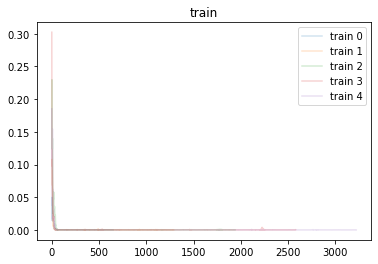

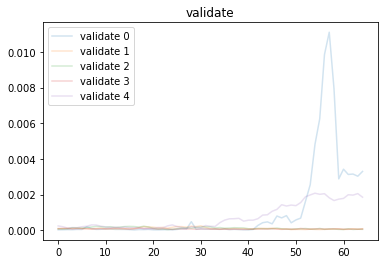

In [18]:
losses = []
losses_after = []
# Training loop
i = 0

# N split cross validation
for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X_train))):    
    model = LSTM(input_dim=input_size, 
             hidden_dim=hidden_size,
             output_dim=output_size,
             num_layers=num_layers).to(device)
    #     model = LSTM(input_size=input_size,
    #                  hidden_size=hidden_size,
    #                  num_layers=num_layers,
    #                  output_size=output_size).to(device)
    #      input_dim, hidden_dim, num_layers, output_dim
    criterion = torch.nn.MSELoss()

    # https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    print(f'Train Idx [{min(train_index)}:{max(train_index)}] ')
    print(f'Test  Idx [{min(test_index)}:{max(test_index)}]')
    fold_X_train, fold_X_test = X_train[train_index], X_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

    # Convert to DataLoader for easy batching
    fold_train_data   = torch.utils.data.TensorDataset(fold_X_train, fold_y_train)
    fold_train_loader = torch.utils.data.DataLoader(dataset=fold_train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    
    for epoch in tqdm.tqdm_notebook(range(num_epochs), leave=False):
        for fold_batch_X, fold_batch_y in fold_train_loader:
            i+=1
            fold_batch_X, fold_batch_y = fold_batch_X.to(device), fold_batch_y.to(device)

            # Backward and optimize
            # Forward pass
            fold_batch_X_pred = model(fold_batch_X)
            if i%10==0:
                print(fold_batch_X_pred.reshape(-1).cpu().detach().numpy()[:10])
            loss = criterion(fold_batch_X_pred, fold_batch_y)
            losses.append([loss.item(), 0, idx])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        fold_val_test_data   = torch.utils.data.TensorDataset(fold_X_test, fold_y_test)
        fold_val_test_loader = torch.utils.data.DataLoader(dataset=fold_val_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

        predictions = []
        for fold_val_batch_X, fold_val_batch_y in fold_val_test_loader:
            fold_val_batch_X, fold_val_batch_y = fold_val_batch_X.to(device), fold_val_batch_y.to(device)
            fold_val_batch_X_pred = model(fold_val_batch_X)
            # predictions.extend(outputs.cpu().numpy())
            loss = criterion(fold_val_batch_X_pred, fold_val_batch_y)
#             print(loss.item())
            losses.append([loss.item(), 1, idx])

#     model.train()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==0), losses) )),
                 label=f'train {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'train')
    plt.show()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==1), losses) )),
                    label=f'validate {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'validate')
    plt.show()
#     break


In [19]:
model.eval()

LSTM(
  (lstm): LSTM(1, 40, num_layers=3, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [37]:

X_test_pred = model(X_test.to(device)).cpu()
X_test_pred.shape

X_test_loss = criterion(X_test_pred, y_test)
print("X Test Loss:",X_test_loss.item())

X Test Loss: 0.0016349995275959373


In [38]:
X_test_pred = X_test_pred.detach().numpy()

In [92]:
X_test_pred.shape

torch.Size([1, 1])

In [42]:
X_test_pred_inv = scaler.inverse_transform(X_test_pred)
y_test_inv = scaler.inverse_transform(y_test)

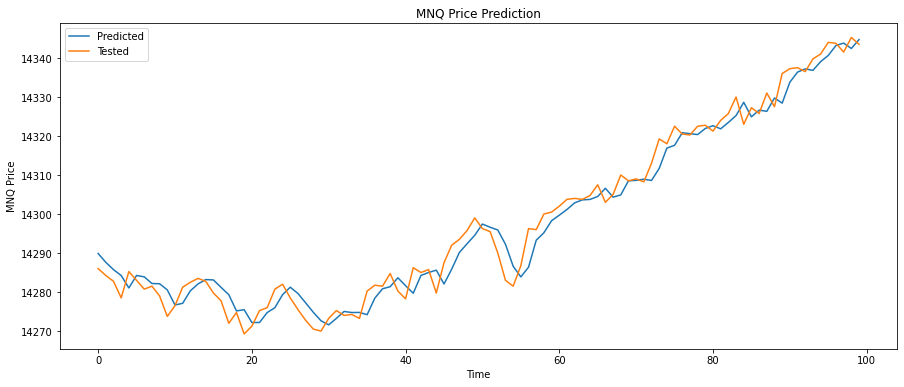

In [53]:
figure, axes = plt.subplots(figsize=(15, 6))
I = 0
N = 100
axes.plot(X_test_pred_inv[I:I+N]+30, label='Predicted')
axes.plot(y_test_inv[I:I+N], label='Tested')
plt.title('MNQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('MNQ Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()

In [122]:
X_test[10].reshape(-1)

tensor([-0.7341, -0.7345, -0.7307, -0.7224, -0.7292, -0.7292, -0.7288, -0.7224,
        -0.7250, -0.7345, -0.7326, -0.7379, -0.7439, -0.7522, -0.7492, -0.7458,
        -0.7473, -0.7371, -0.7439, -0.7488, -0.7556, -0.7563, -0.7465, -0.7522,
        -0.7522, -0.7631, -0.7638, -0.7680, -0.7706, -0.7718, -0.7687, -0.7695,
        -0.7638, -0.7635, -0.7695, -0.7627, -0.7635, -0.7631, -0.7605, -0.7687,
        -0.7691, -0.7695, -0.7763, -0.7827, -0.7838, -0.7812, -0.7770, -0.7770,
        -0.7751, -0.7812, -0.7838, -0.7861, -0.7925, -0.7823, -0.7857, -0.7891,
        -0.7879, -0.7917, -0.7996])

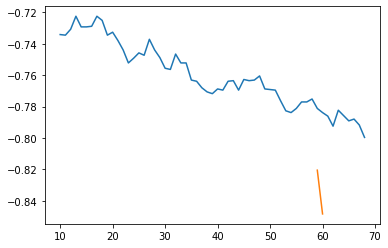

In [149]:
pred_shift = 0
pred_size = 10
__len = X_test.shape[1]

predictions = []
new_data = X_test[[pred_shift]]

for i in range(pred_size):
    data_pred = model(new_data.to(device)).cpu()
    predictions.append(data_pred.detach().numpy()[0][0])
    new_data = np.concatenate([new_data.reshape(-1),data_pred.detach().numpy()[0]])
    # print(predictions,X_test[pred_shift+i+1][-1].detach().numpy()[0])
    # print(new_data)
    new_data = new_data[1:].reshape(1,__len,1)
    new_data = torch.tensor(new_data, dtype=torch.float32)
# plt.plot(X_test[pred_shift])
__x = 10
plt.plot(range(__x,__len+__x),X_test[__x])
plt.plot(range(__len,len(predictions)+__len), predictions)
plt.show()

In [94]:
predictions = np.array(predictions)

In [97]:
predictions_inv = scaler.inverse_transform(predictions.reshape((10,1))).reshape(-1)
predictions_inv

array([14259.883, 14241.388, 14223.929, 14207.994, 14193.166, 14179.278,
       14166.265, 14154.1  , 14142.76 , 14132.229], dtype=float32)

In [105]:
X_inv = X_test[59]
X_inv = scaler.inverse_transform(X_inv).reshape(-1)
X_inv

array([14285.99998799, 14284.25001626, 14282.75000092, 14278.49999045,
       14285.2500001 , 14282.99999689, 14280.74999367, 14281.49998155,
       14278.99998237, 14273.74998805, 14276.49998319, 14281.24998559,
       14282.50000496, 14283.49998881, 14282.75000092, 14279.75000982,
       14277.75000256, 14272.00001632, 14274.75001146, 14269.24998161,
       14271.24998887, 14275.25000338, 14275.99999127, 14280.74999367,
       14282.00001304, 14278.49999045, 14275.49999934, 14272.7500042 ,
       14270.50000098, 14270.00000906, 14273.24999613, 14275.25000338,
       14273.99998401, 14274.25001954, 14273.24999613, 14280.25000174,
       14281.75001708, 14281.49998155, 14284.75000818, 14280.25000174,
       14278.24999449, 14286.24998395, 14285.00000414, 14285.74999203,
       14279.75000982, 14287.50000332, 14292.00000976, 14293.49998553,
       14295.74998875, 14299.00001538, 14296.24998067, 14295.49999279,
       14290.0000025 , 14282.99999689, 14281.49998155, 14286.75001544,
      

In [114]:
predictions

array([-0.8205153 , -0.84838045, -0.87468445, -0.89869034, -0.9210298 ,
       -0.9419546 , -0.9615593 , -0.9798881 , -0.996971  , -1.0128391 ],
      dtype=float32)

In [113]:
X_test[10]

tensor([[-0.7341],
        [-0.7345],
        [-0.7307],
        [-0.7224],
        [-0.7292],
        [-0.7292],
        [-0.7288],
        [-0.7224],
        [-0.7250],
        [-0.7345],
        [-0.7326],
        [-0.7379],
        [-0.7439],
        [-0.7522],
        [-0.7492],
        [-0.7458],
        [-0.7473],
        [-0.7371],
        [-0.7439],
        [-0.7488],
        [-0.7556],
        [-0.7563],
        [-0.7465],
        [-0.7522],
        [-0.7522],
        [-0.7631],
        [-0.7638],
        [-0.7680],
        [-0.7706],
        [-0.7718],
        [-0.7687],
        [-0.7695],
        [-0.7638],
        [-0.7635],
        [-0.7695],
        [-0.7627],
        [-0.7635],
        [-0.7631],
        [-0.7605],
        [-0.7687],
        [-0.7691],
        [-0.7695],
        [-0.7763],
        [-0.7827],
        [-0.7838],
        [-0.7812],
        [-0.7770],
        [-0.7770],
        [-0.7751],
        [-0.7812],
        [-0.7838],
        [-0.7861],
        [-0.

59

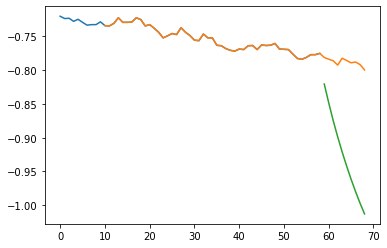

In [83]:
X_test_pred.

tensor([[-0.8205]], grad_fn=<CopyBackwards>)

In [77]:
X_test_pred.detach().numpy()[0]

array([-0.8205153], dtype=float32)

(1, 59, 1)

array([-0.8205153], dtype=float32)

In [17]:
losses_1 = list(filter(lambda x: x[1]==0,losses))
losses_1 = np.array(losses_1)

In [18]:
len(losses_after)

15250

In [19]:
losses_after = np.array(losses_after)

In [20]:
np.sum(losses_1[::,0] - losses_after[::,0])

0.0

In [87]:
for batch_X, batch_y in test_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    outputs = model(batch_X)
    # predictions.extend(outputs.cpu().numpy())
    loss = criterion(outputs, batch_y)
    break
#             print(loss.item())

#     losses.append([loss.item(), 1,idx])

In [88]:
outputs.shape

torch.Size([256, 1])

In [158]:
local_loss = []
for idx in range(63):
    local_loss.append([batch_y[idx].to('cpu').reshape((-1,)).detach().numpy()[0], outputs[idx].to('cpu').detach().numpy()[0]])

In [159]:
u = np.array(local_loss)
_yhat = u[::,0]
_y = u[::,1]

In [160]:
loss

tensor(0.1520, device='cuda:0')

In [161]:
((_yhat-_y)**2).mean()

0.15195942

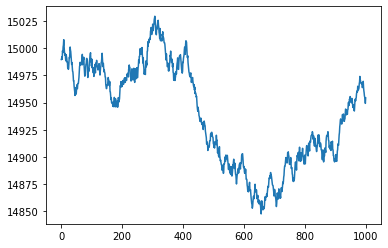

In [93]:
plt.plot(df['close'].values[:1000])

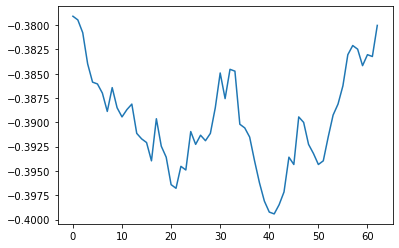

In [162]:
plt.plot(_yhat-_y)
plt.show()

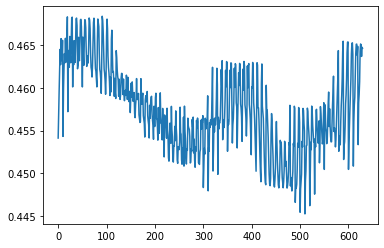

In [26]:
plt.plot(outputs.reshape((-1,)).to('cpu').detach().numpy())

In [45]:
outputs.shape

torch.Size([63, 10, 1])

In [50]:
np.mean(outputs.item(), axis=1)

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
 for fold_val_batch_X, fold_val_batch_y in fold_val_test_loader:
            fold_val_batch_X, fold_val_batch_y = fold_val_batch_X.to(device), fold_val_batch_y.to(device)
            fold_val_batch_X_pred = model(fold_val_batch_X)
            # predictions.extend(outputs.cpu().numpy())
            loss = criterion(fold_val_batch_X_pred, fold_val_batch_y)
#             print(loss.item())
            losses.append([loss.item(), 1, idx])

In [21]:
fold_val_batch_X_pred

tensor([[-0.0822],
        [-0.0773],
        [-0.0812],
        [-0.0834],
        [-0.0819],
        [-0.0805],
        [-0.0867],
        [-0.0881],
        [-0.0886],
        [-0.0923],
        [-0.0837],
        [-0.0891],
        [-0.0918],
        [-0.0975],
        [-0.0982],
        [-0.0934],
        [-0.0940],
        [-0.0862],
        [-0.0888],
        [-0.0872],
        [-0.0883],
        [-0.0867],
        [-0.0813],
        [-0.0739],
        [-0.0794],
        [-0.0737],
        [-0.0738],
        [-0.0849],
        [-0.0860],
        [-0.0875],
        [-0.0923],
        [-0.0970],
        [-0.1008],
        [-0.1030],
        [-0.1033],
        [-0.1013],
        [-0.0986],
        [-0.0914],
        [-0.0929],
        [-0.0833],
        [-0.0842],
        [-0.0891],
        [-0.0912],
        [-0.0932],
        [-0.0924],
        [-0.0873],
        [-0.0826],
        [-0.0805],
        [-0.0769],
        [-0.0704],
        [-0.0684],
        [-0.0693],
        [-0.

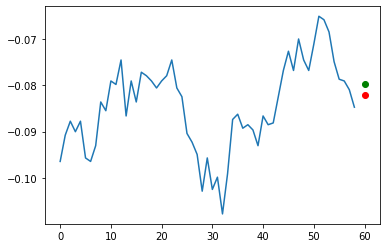

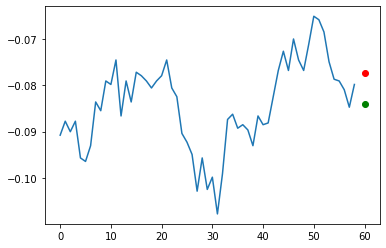

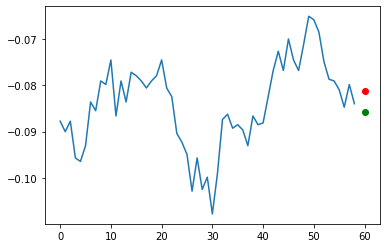

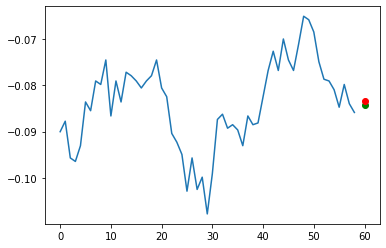

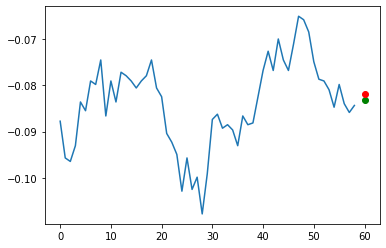

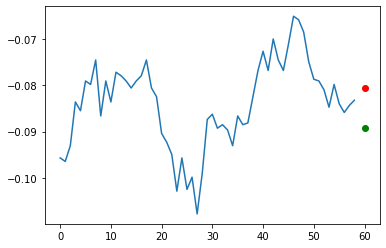

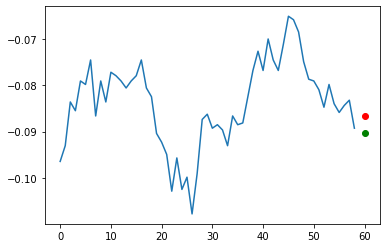

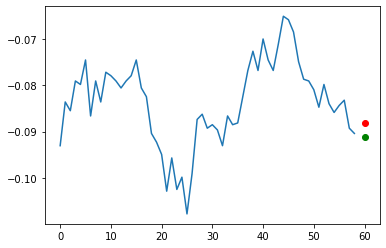

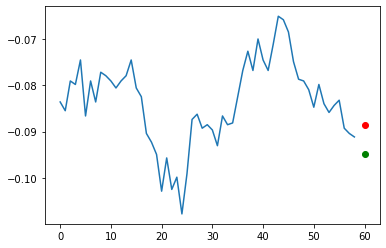

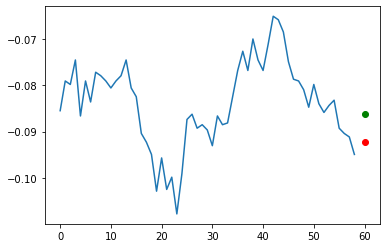

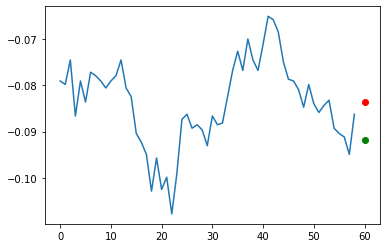

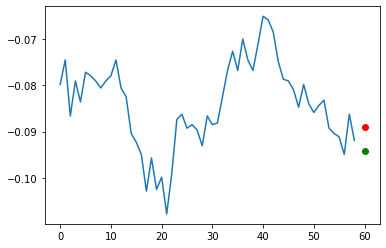

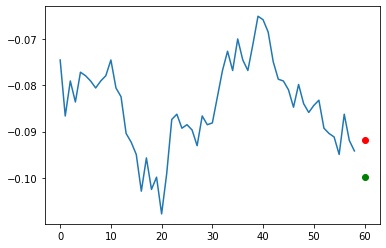

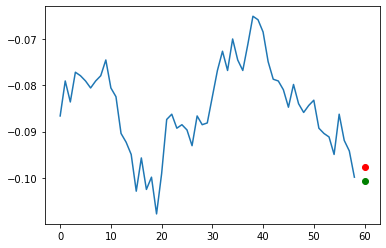

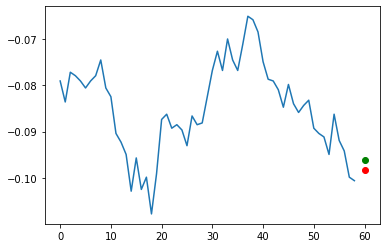

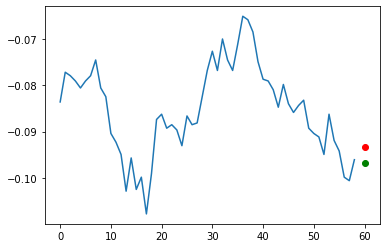

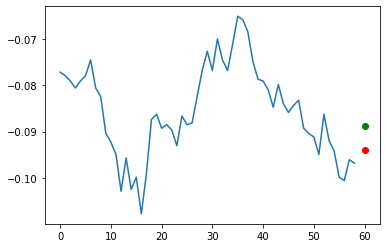

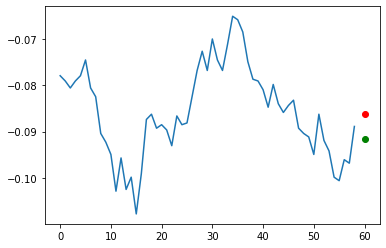

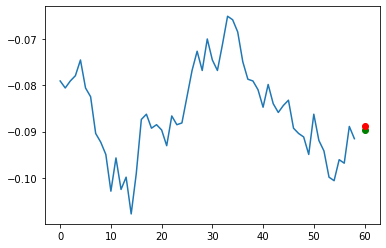

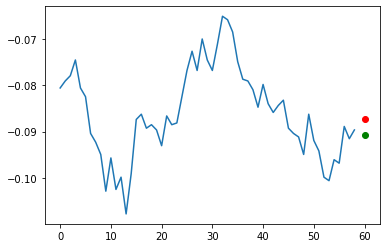

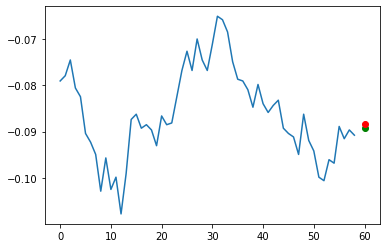

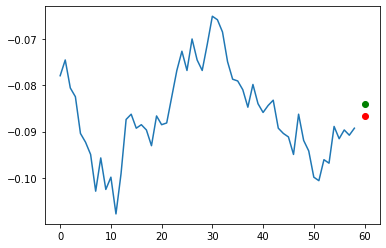

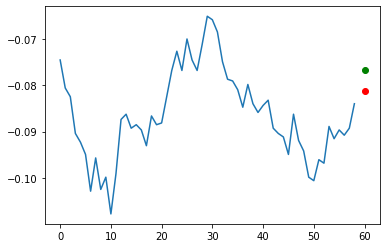

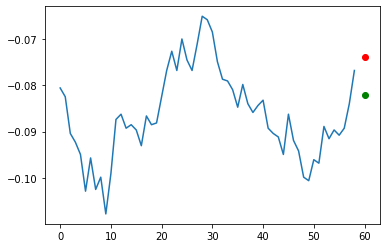

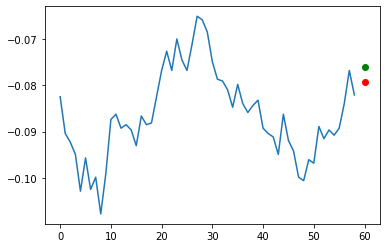

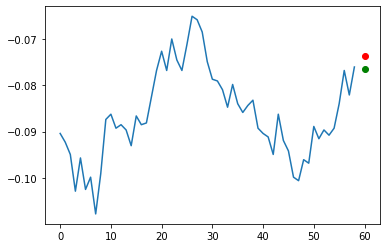

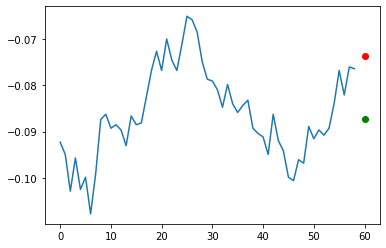

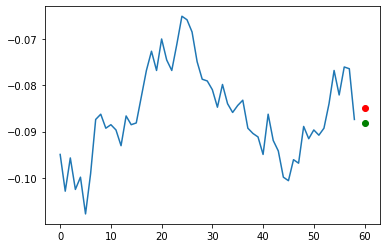

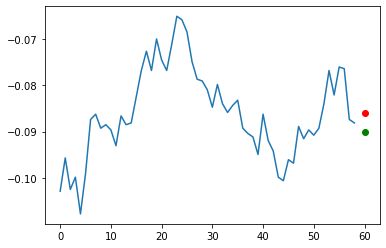

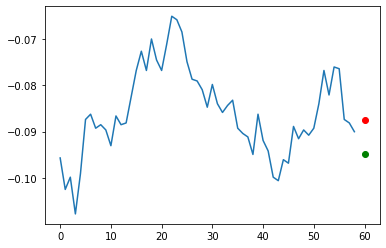

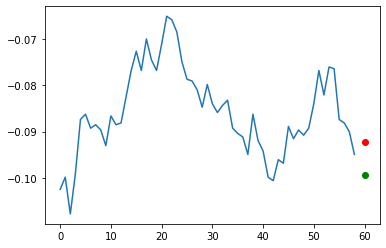

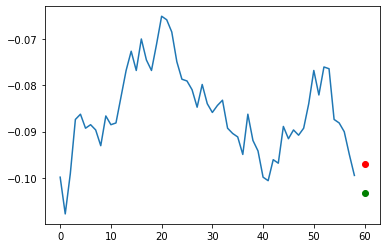

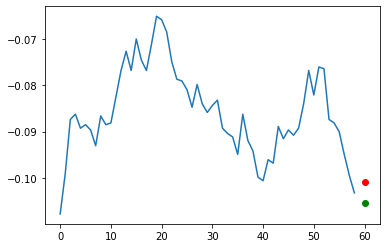

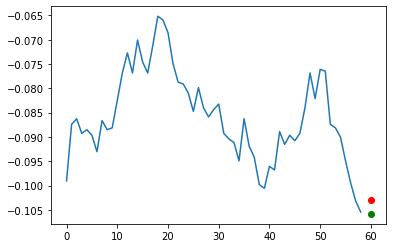

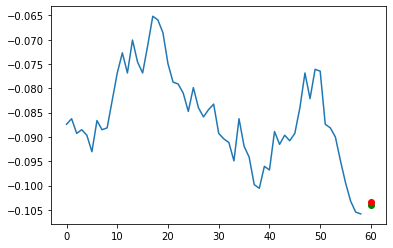

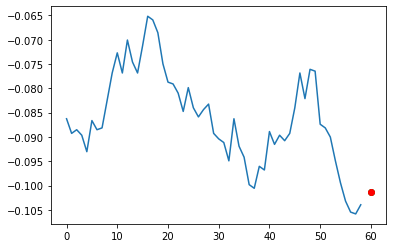

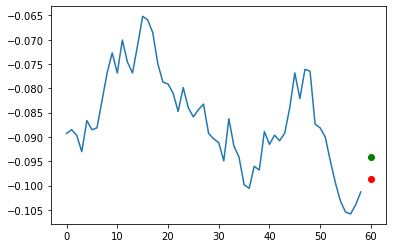

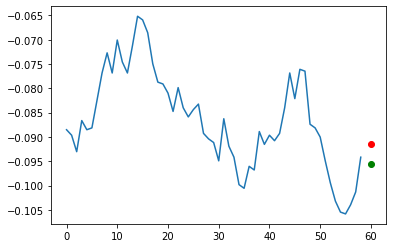

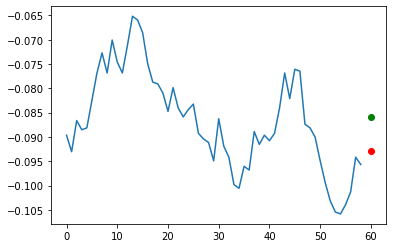

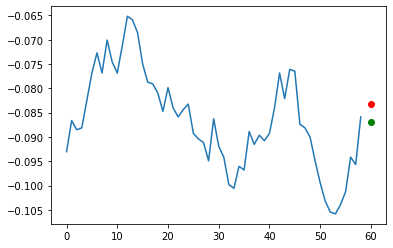

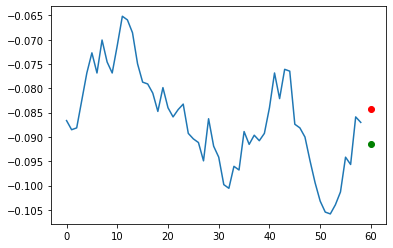

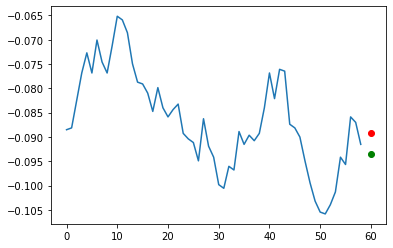

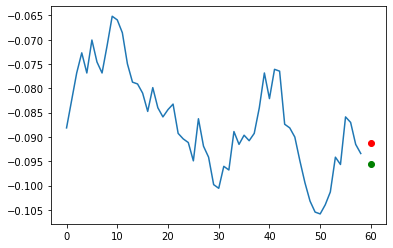

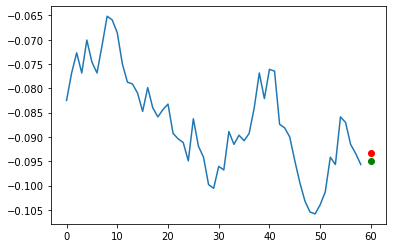

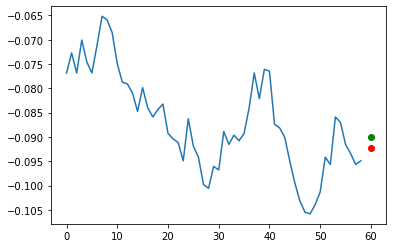

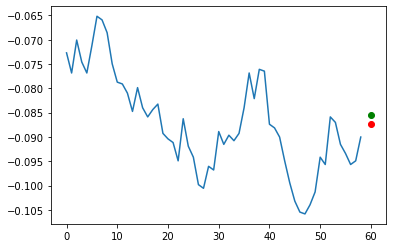

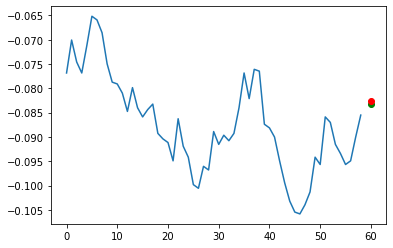

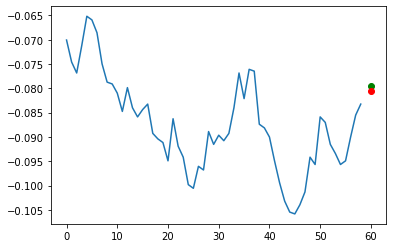

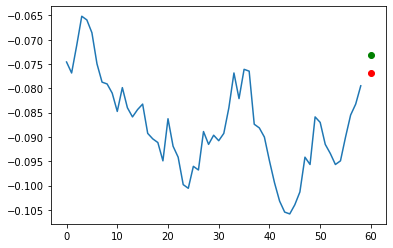

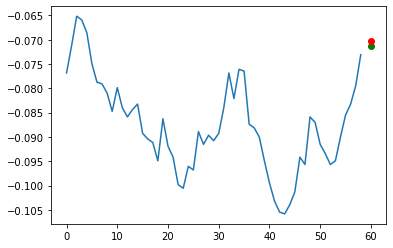

In [20]:
for idx in range(50):
    plt.plot(fold_val_batch_X[idx].to('cpu').reshape((-1,)))
    plt.scatter(60,fold_val_batch_y[idx].to('cpu').reshape((-1,)), color='green')
    plt.scatter(60, np.mean(fold_val_batch_X_pred[idx].to('cpu').detach().numpy().reshape((-1,))), color='red')
    plt.show()

In [45]:
loss

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)

In [30]:
list(range(1))

[0]

In [21]:
?filter

In [23]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(fold_val_batch_X_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(fold_val_batch_y.cpu().detach().numpy())
y_test = y_test.reshape((-1,1))

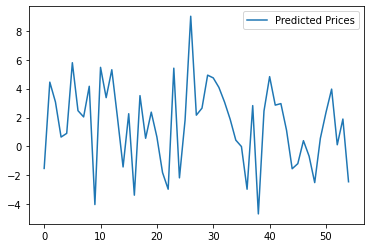

In [25]:
plt.plot((predictions - y_test).reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()